# 1. Import the Packages

In [1]:
# Standard Python libraries
import os
import random
import time
from datetime import datetime

# Libraries for data manipulation and visualization
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Libraries for detection and classification
from mtcnn import MTCNN 
from keras_facenet import FaceNet

# 2. Data Set Aquisition

Capturing data set for new user from camera using MTCNN detector

In [2]:
## BELOM BERES (LATER)

def captureImage():
    # initialize the MTCNN detector
    detector = MTCNN()

    # initialize the video capture object for the default camera
    cam = cv2.VideoCapture(0)

    # initialize catured frame variable

    while True:
        # read the frame from the camera
        ret, frame = cam.read()

        # detect faces using MTCNN
        faces = detector.detect_faces(frame)

        # draw bounding boxes around the faces
        for face in faces:
            x, y, w, h = face['box']
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # show the resulting frame
        cv2.imshow('Real-time Face Detection', frame)

        # press 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # release the video capture object and close all windows
    cam.release()
    cv2.destroyAllWindows()

## 3. Preprocessing Image

### 3.1. MTCNN Part

Extract faces from captured image using MTCNN and resize the image into 160x160. After that, do flip and contrast stretching to resized image

In [3]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    def extract_faces(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hasil_deteksi = self.detector.detect_faces(img)

        # Getting x, y, w, h from image 'box'
        x, y, w, h = hasil_deteksi[0]['box']
        x, y, w, h = abs(x), abs(y), abs(w), abs(h)

        # Draw rectangle box on detected face
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 10)

        wajah = img[y:y + h, x:x + w]
        wajah_arr = cv2.resize(wajah, self.target_size)
        return wajah_arr

    def load_faces(self, dir, class_label):
        FACES = []
        Y = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

            except Exception as e:
                pass
        return FACES, Y

    def parse_filename(self, filename):
        # Mengambil NIM dan Nama dari nama file dengan pola "NIM_Nama_i.jpg"
        nim, nama, _ = filename.split('_')
        return nim, nama

    def load_classes_after_augmentation(self, output_folder=None):
        # Inisialisasi kembali X dan Y
        X = []
        Y = []

        # Membuat subdirektori yang belum ada
        if output_folder:
            for class_label in set(self.Y):  # Menggunakan set(Y) untuk mendapatkan kelas unik
                class_dir = os.path.join(output_folder, class_label)
                if not os.path.exists(class_dir):
                    os.makedirs(class_dir)

        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES, labels = self.load_faces_after_augmentation(path, sub_dir, output_folder=output_folder)
            X.extend(FACES)
            Y.extend(labels)

        return X, Y

    def load_faces_after_augmentation(self, dir, class_label, output_folder=None):
        FACES = []
        Y = []
        for i, im_name in enumerate(os.listdir(dir)):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

                nim, nama = self.parse_filename(im_name)

                # Check if the output folder exists for the current class label
                class_output_folder = os.path.join(output_folder, class_label)
                if not os.path.exists(class_output_folder):
                    os.makedirs(class_output_folder)    

                # Jika ingin melakukan augmentasi pada citra di sini, tambahkan proses augmentasi di sini.
                flipped_face = cv2.flip(single_face, 1)  # 1 for horizontal flip
                FACES.append(flipped_face)
                Y.append(class_label)

                contrast_stretched_face = self.contrast_stretching(single_face)
                FACES.append(contrast_stretched_face)
                Y.append(class_label)

                if output_folder:
                    index_start = 1 + i * 3

                    # Simpan citra dengan penamaan yang mengikuti nim dan nama
                    original_filename = f"{nim}_{nama}_{index_start}.jpg"
                    output_path_original = os.path.join(output_folder, class_label, original_filename)
                    cv2.imwrite(output_path_original, cv2.cvtColor(single_face, cv2.COLOR_RGB2BGR))

                    flipped_filename = f"{nim}_{nama}_{index_start + 1}.jpg"
                    output_path_flip = os.path.join(output_folder, class_label, flipped_filename)
                    cv2.imwrite(output_path_flip, cv2.cvtColor(flipped_face, cv2.COLOR_RGB2BGR))

                    stretched_filename = f"{nim}_{nama}_{index_start + 2}.jpg"
                    output_path_stretch = os.path.join(output_folder, class_label, stretched_filename)
                    cv2.imwrite(output_path_stretch, cv2.cvtColor(contrast_stretched_face, cv2.COLOR_RGB2BGR))

            except Exception as e:
                pass
        return FACES, Y

    def contrast_stretching(self, image):
        # Compute minimum and maximum pixel values for each channel
        min_val = np.min(image, axis=(0, 1))
        max_val = np.max(image, axis=(0, 1))

        # Perform contrast stretching for each channel
        stretched = (image - min_val) * (255.0 / (max_val - min_val))
        stretched = np.clip(stretched, 0, 255).astype(np.uint8)

        return stretched

In [4]:
# Ask the user if they want to use the existing dataset or capture new images
use_existing_data = input("Do you want to use the last existing dataset (y/n)? ")
faces_dataset_filename = "dataframe_and_model_files/loadedfaces.npz"

# If the user wants to use the existing dataset, load the dataset from the .npz file
if use_existing_data.lower() == 'y':
    # Loads the faces and labels from the compressed .npz file.
    loaded_data = np.load("dataframe_and_model_files/loadedfaces.npz")
    X = loaded_data["X"]
    Y = loaded_data["Y"]

    print(f"Faces Dataset successfully loaded from {faces_dataset_filename}")
    print(f"===============================================")

    print(f"Unique Labels After Augmentation: {set(Y)}")
    print(f'Total Images in Array After Augmentation: {len(X)} images')

if use_existing_data.lower() == 'n':
    # Gunakan kelas FACELOADING dengan folder direktori "capturedfaces"
    face_loader = FACELOADING("capturedfaces")
    X, Y = face_loader.load_classes_after_augmentation(output_folder="datawajah")

    print(f"Unique Labels After Augmentation: {set(Y)}")
    print(f'Total Images in Array After Augmentation: {len(X)} images')

    # Saves the loaded faces and labels into a compressed .npz file
    joblib.dump()
    np.savez_compressed(faces_dataset_filename, X=X, Y=Y)
    print()
    print("File loaded and saved to dataframe_and_model_files/loadedfaces.npz")

Faces Dataset successfully loaded from dataframe_and_model_files/loadedfaces.npz
Unique Labels After Augmentation: {'shabrina-katresnawati', 'muhammad-tegar-heidar-gunawan', 'rizky-mahesa-ramadhan', 'ismail-nurhapid-jamal', 'zidan-nuryawan-pratomo', 'rahayu-puspitasari', 'rizky-nurhadhi'}
Total Images in Array After Augmentation: 2100 images


Creating dataframe that containing available images from extracted faces and checking total files in the folder

In [5]:
def create_dataframe():
    # Initialize main dataset folder
    dataset_folder = "datawajah"
    root_folder = dataset_folder

    data = []
  
    # Iterate through the main folder and subfolders
    for root, dirs, files in os.walk(root_folder):
        for file in files:
        # Get the subfolder name (classes)
            classes = os.path.basename(root)

            # Get the full path of the image
            image_path = os.path.join(classes, file)

            # Add data to the list
            data.append({'Classes': classes, 'File Name': file, 'Image Path': image_path})

    # Create a dataframe from the data list
    df = pd.DataFrame(data)

    # Save the dataframe to an Excel file
    excel_file_name = 'dataframe_and_model_files/faces_train_data.xlsx'
    df.to_excel(excel_file_name, index=False)

    print("Dataframe successfully saved to", excel_file_name)

    return df

In [6]:
def total_images_per_class(df):
    # Function to calculate the total number of files in a folder.
    def total_file(classes):
        return len(df[df['Classes'] == classes].values)

    # Iterate through unique classes and print the total number of files for each class
    unique_classes = df['Classes'].unique()
    print("Total number of images in each class :")
    for classes in unique_classes:
        count = total_file(classes)
        print(f"'{classes}': {count} images")

In [7]:
# Create the dataframe
df = create_dataframe()

# Calculate and print the total number of images in each class
total_images_per_class(df)

Dataframe successfully saved to dataframe_and_model_files/faces_train_data.xlsx
Total number of images in each class :
'ismail-nurhapid-jamal': 300 images
'muhammad-tegar-heidar-gunawan': 300 images
'rahayu-puspitasari': 300 images
'rizky-mahesa-ramadhan': 300 images
'rizky-nurhadhi': 300 images
'shabrina-katresnawati': 300 images
'zidan-nuryawan-pratomo': 300 images


In [8]:
df.sample(10)

,Classes,File Name,Image Path
1256,rizky-nurhadhi,1207070113_RIZKY NURHADHI_15.jpg,rizky-nurhadhi\1207070113_RIZKY NURHADHI_15.jpg
1662,shabrina-katresnawati,1207070136_SHABRINA KATRESNAWATI_245.jpg,shabrina-katresnawati\1207070136_SHABRINA KATR...
1630,shabrina-katresnawati,1207070136_SHABRINA KATRESNAWATI_216.jpg,shabrina-katresnawati\1207070136_SHABRINA KATR...
411,muhammad-tegar-heidar-gunawan,1207070080_MUHAMMAD TEGAR HEIDAR GUNAWAN_2.jpg,muhammad-tegar-heidar-gunawan\1207070080_MUHAM...
1940,zidan-nuryawan-pratomo,1207070132_ZIDAN NURYAWAN P_225.jpg,zidan-nuryawan-pratomo\1207070132_ZIDAN NURYAW...
1299,rizky-nurhadhi,1207070113_RIZKY NURHADHI_189.jpg,rizky-nurhadhi\1207070113_RIZKY NURHADHI_189.jpg
1082,rizky-mahesa-ramadhan,1207070112_RIZKY MAHESA RAMADHAN_263.jpg,rizky-mahesa-ramadhan\1207070112_RIZKY MAHESA ...
702,rahayu-puspitasari,1207070094_RAHAYU PUSPITASARI_191.jpg,rahayu-puspitasari\1207070094_RAHAYU PUSPITASA...
1786,shabrina-katresnawati,1207070136_SHABRINA KATRESNAWATI_87.jpg,shabrina-katresnawati\1207070136_SHABRINA KATR...
1836,zidan-nuryawan-pratomo,1207070132_ZIDAN NURYAWAN P_131.jpg,zidan-nuryawan-pratomo\1207070132_ZIDAN NURYAW...


### 3.2. FaceNet Part

Embed the dataset to 512 dimension image (1x1x512) and save it into .npz file

In [9]:
embedder = FaceNet()

def get_embedding(face_image):
    face_image = face_image.astype('float32') # 3D(160x160x3)
    face_image = np.expand_dims(face_image, axis=0) # 4D(Nonex160x160x3)
    
    yhat = embedder.embeddings(face_image)

    return yhat[0] #512D image (1x1x152)

In [10]:
embedded_data_loaded = input("Do you want to load last saved embedded data from the file 'dataframe_and_model_files/embedded_dataset.npz' (y/n)? ")
embedded_file_name = "dataframe_and_model_files/embedded_dataset.npz"

if embedded_data_loaded.lower() == 'y':
    # Load the embedded data from the npz file
    loaded_data = np.load('dataframe_and_model_files/embedded_dataset.npz', allow_pickle=True)
    EMBEDDED_X = loaded_data['arr_0']
    Y = loaded_data['arr_1']

    # Reload the arrays of original X
    loaded_data = np.load("dataframe_and_model_files/loadedfaces.npz")
    X = loaded_data["X"]

    print(f"Embedded dataset successfully loaded from {embedded_file_name}")
    print()
    print(f"Unique Labels: {set(Y)}")
    print(f'Total Embedded Images in Array: {len(EMBEDDED_X)}')
    
if embedded_data_loaded.lower() == 'n':
    # Embedding the datasets and save it to the npz file
    EMBEDDED_X = []

    for face_image in X:
        EMBEDDED_X.append(get_embedding(face_image))

    EMBEDDED_X = np.asarray(EMBEDDED_X)
    np.savez_compressed(embedded_file_name, EMBEDDED_X, Y)
    print("Embedded dataset successfully saved to", embedded_file_name)
    print("===============================================")
    print(f"Unique Labels: {set(Y)}")
    print(f'Total Embedded Images in Array: {len(EMBEDDED_X)}')

Embedded dataset successfully loaded from dataframe_and_model_files/embedded_dataset.npz

Unique Labels: {'shabrina-katresnawati', 'muhammad-tegar-heidar-gunawan', 'rizky-mahesa-ramadhan', 'ismail-nurhapid-jamal', 'zidan-nuryawan-pratomo', 'rahayu-puspitasari', 'rizky-nurhadhi'}
Total Embedded Images in Array: 2100


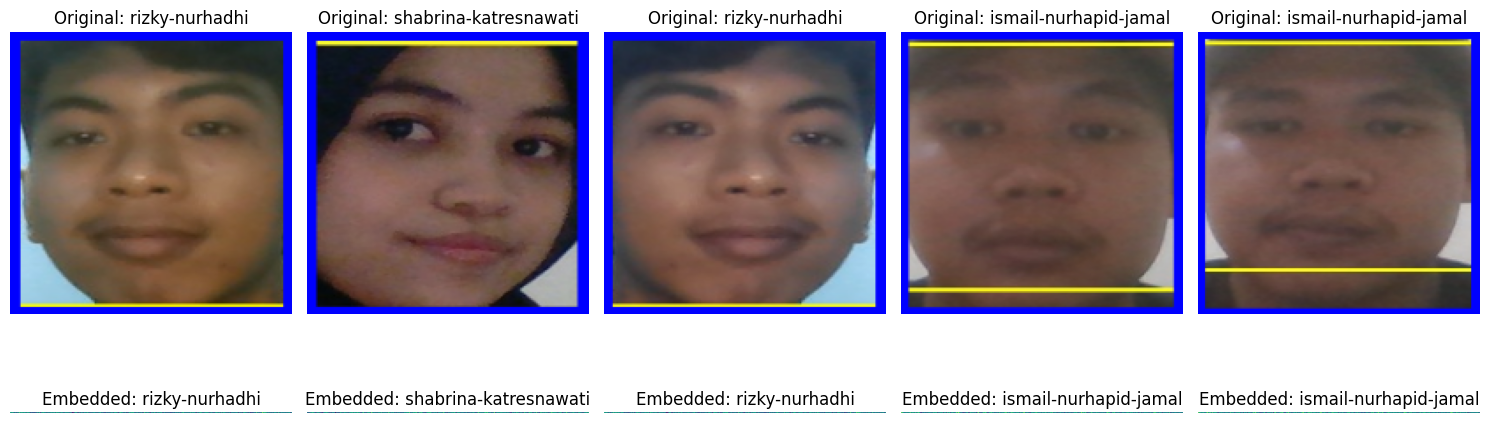

In [11]:
# Choose a few random indices
num_display_samples = 5
sample_indices = random.sample(range(len(EMBEDDED_X)), num_display_samples)

# Display the sample images with their corresponding labels and embeddings
plt.figure(figsize=(15, 6))
for i, index in enumerate(sample_indices):
    plt.subplot(2, num_display_samples, i + 1)
    plt.imshow(X[index])
    plt.title(f"Original: {Y[index]}")
    plt.axis('off')

    plt.subplot(2, num_display_samples, i + num_display_samples + 1)
    plt.imshow(EMBEDDED_X[index].reshape((1, -1)))
    plt.title(f"Embedded: {Y[index]}")
    plt.axis('off')

plt.tight_layout()

In [12]:
# Check correspondence between images in 'X' and labels in 'Y'
for i in range(len(X)):
    print(f"Label: {Y[i]}, File Name: {df['File Name'].iloc[i]}")

Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_1.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_10.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_100.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_101.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_102.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_103.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_104.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_105.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_106.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_107.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_108.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_109.jpg
Label: ismail-nurha

## 4. SVM Classification

### 4.1. K-Fold Cross Validation

Fold 1 - Train Accuracy: 100.00%, Precision: 100.00%%, Recall: 100.00%%, F1 Score: 100.00%
Fold 1 - Test Accuracy: 100.00%

Fold 2 - Train Accuracy: 100.00%, Precision: 100.00%%, Recall: 100.00%%, F1 Score: 100.00%
Fold 2 - Test Accuracy: 100.00%

Fold 3 - Train Accuracy: 100.00%, Precision: 100.00%%, Recall: 100.00%%, F1 Score: 100.00%
Fold 3 - Test Accuracy: 100.00%

Fold 4 - Train Accuracy: 100.00%, Precision: 100.00%%, Recall: 100.00%%, F1 Score: 100.00%
Fold 4 - Test Accuracy: 100.00%

Fold 5 - Train Accuracy: 100.00%, Precision: 100.00%%, Recall: 100.00%%, F1 Score: 100.00%
Fold 5 - Test Accuracy: 100.00%

Average Accuracy: 100.0%
Average Precision: 100.0%
Average Recall: 100.0%
Average F1 Score: 100.0%


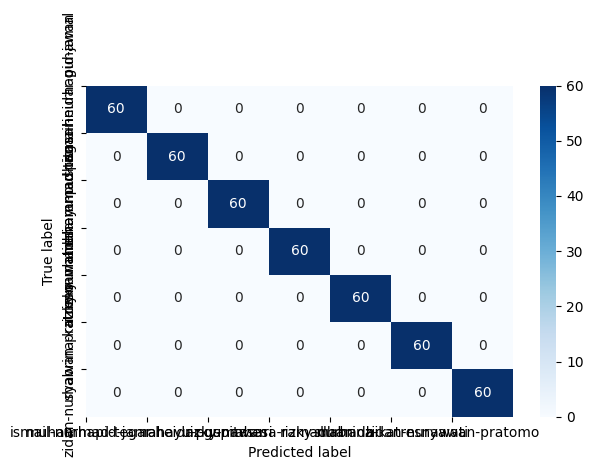

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the npz file
loaded_data = np.load('dataframe_and_model_files/embedded_dataset.npz', allow_pickle=True)
X = loaded_data['arr_0']
Y = loaded_data['arr_1']

# Perform Stratified K-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store the train and test embeddings and labels
X_train_folds = []
X_test_folds = []
y_train_folds = []
y_test_folds = []

# Perform Stratified K-fold cross validation
for train_index, test_index in skf.split(X, Y):
    X_train_folds.append(X[train_index])
    X_test_folds.append(X[test_index])
    y_train_folds.append(np.take(Y, train_index))
    y_test_folds.append(Y[test_index])

# Initialize the SVM classifier
svm_classifier = svm.SVC(kernel='linear', probability=True)

# Initialize empty lists to store the train and test predictions
train_predictions = []
test_predictions = []

# Store the trained model and test predictions for each fold
fold_models = []
fold_test_predictions = []
model_filename = "dataframe_and_model_files/mtcnn_svm_model_facercognition.npz"

for i in range(skf.get_n_splits()):
    svm_classifier.fit(X_train_folds[i], y_train_folds[i])
    train_predictions.append(svm_classifier.predict(X_train_folds[i]))
    test_predictions.append(svm_classifier.predict(X_test_folds[i]))

    # Save the trained model, test predictions, and true labels for this fold
    fold_models.append(svm_classifier)
    fold_test_predictions.append(np.vstack((test_predictions[i], y_test_folds[i])).T)

# Save the models, test predictions, and true labels to a file
np.savez(model_filename, models=fold_models, test_predictions=fold_test_predictions)

# Calculate the accuracy, precision, recall, and F1 score for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
for i in range(skf.get_n_splits()):
    accuracies.append(accuracy_score(y_train_folds[i], train_predictions[i]))
    precisions.append(precision_score(y_train_folds[i], train_predictions[i], average='weighted'))
    recalls.append(recall_score(y_train_folds[i], train_predictions[i], average='weighted'))
    f1_scores.append(f1_score(y_train_folds[i], train_predictions[i], average='weighted'))
    print(f'Fold {i+1} - Train Accuracy: {accuracies[i]*100:.2f}%, '
          f'Precision: {precisions[i]*100:.2f}%%, '
          f'Recall: {recalls[i]*100:.2f}%%, '
          f'F1 Score: {f1_scores[i]*100:.2f}%')
    print(f'Fold {i+1} - Test Accuracy: {accuracy_score(y_test_folds[i], test_predictions[i])*100:.2f}%')
    print()

# Calculate the average accuracy, precision, recall, and F1 score
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

print(f'Average Accuracy: {avg_accuracy*100}%')
print(f'Average Precision: {avg_precision*100}%')
print(f'Average Recall: {avg_recall*100}%')
print(f'Average F1 Score: {avg_f1_score*100}%')

# Calculate the confusion matrix for each fold
confusion_matrices = []
for i in range(skf.get_n_splits()):
    y_true = y_test_folds[i]
    y_pred = test_predictions[i]
    confusion_mtx = confusion_matrix(y_true, y_pred)
    confusion_matrices.append(confusion_mtx)

# Sum up the confusion matrices
confusion_mtx = np.sum(confusion_matrices, axis=0)

# Get the unique classes from the true labels
classes = np.unique(y_true)

# Create a confusion matrix with labels instead of integer values
confusion_mtx_labels = confusion_matrix(y_true, y_pred, labels=classes)

# Plot the confusion matrix with labels instead of integer values
sns.heatmap(confusion_mtx_labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Set the xticklabels and yticklabels to the unique classes
plt.xticks(ticks=range(len(classes)), labels=classes)
plt.yticks(ticks=range(len(classes)), labels=classes)
plt.tight_layout()
plt.show()

In [14]:
import cv2
import numpy as np
import time
from mtcnn import MTCNN
import joblib

# Load MTCNN face detection model
detector = MTCNN()

# Load saved model
model_filename = "dataframe_and_model_files/mtcnn_svm_model_facercognition.npz"
model = np.load(model_filename)

# Initialize the camera
cap = cv2.VideoCapture(0)

# Initialize a variable to keep track of the start time
start_time = time.time()

while True:
    # Capture frame from the camera
    ret, frame = cap.read()

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # If 10 seconds have elapsed, break the loop
    if elapsed_time > 10:
        break

# Release the camera
cap.release()
cv2.destroyAllWindows()

# Capture the frame at the 10th second
while elapsed_time < 10:
    # Capture frame from the camera
    ret, frame = cap.read()

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

# Detect faces in the frame
faces = detector.detect_faces(frame)

# Initialize empty list to store the detected faces
detected_faces = []

# Extract detected faces
for face in faces:
    x, y, w, h = face['box']
    detected_faces.append(frame[y:y+h, x:x+w])

# Recognize faces
recognized_faces = []
for face in detected_faces:
    face = cv2.resize(face, (160, 160))
    face = np.expand_dims(face, axis=0)
    face = face.astype('float32')
    pred = model.predict(face)
    recognized_faces.append(pred[0])

# Print recognized faces
print(recognized_faces)

# Release the camera
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 112ms/step


AttributeError: 'NpzFile' object has no attribute 'predict'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from keras_facenet import FaceNet

# Load the saved model
model_filename = "dataframe_and_model_files/mtcnn_svm_model_facercognition.npz"
loaded_data = np.load(model_filename, allow_pickle=True)
fold_models = loaded_data['models']

# Load the FaceNet model
embedder = FaceNet()

# Initialize the MTCNN face detection algorithm
detector = MTCNN()

# Open the camera
cap = cv2.VideoCapture(0)

while True:
    # Capture a frame from the camera
    ret, frame = cap.read()

    # Detect faces in the frame
    faces = detector.detect_faces(frame)

    # Extract the detected faces as 160x160 RGB images
    extracted_faces = []
    for face in faces:
        x, y, w, h = face['box']
        face_image = frame[y:y+h, x:x+w]
        face_image = cv2.resize(face_image, (160, 160))
        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
        extracted_faces.append(face_image)

    # Embed the extracted faces using the FaceNet model
    embeddings = []
    for face in extracted_faces:
        embedding = embedder.embeddings(np.array([face]))
        embeddings.append(embedding[0])

    # Use the saved SVM model to predict the label of each embedding
    labels = []
    for embedding in embeddings:
        # Reshape the embedding to (1, 128) for the SVM model
        embedding = np.array([embedding.reshape(1, -1)])
        # Use the first model to predict the label
        label = fold_models[0].predict(embedding)[0]
        labels.append(label)

    # Display the predicted labels on the detected faces in the frame
    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, str(labels[i]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Face Recognition', frame)

    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and destroy all windows
cap.release()
cv2.destroyAllWindows()

In [ ]:
# import cv2
# import numpy as np
# import time
# from mtcnn import MTCNN
# from sklearn.externals import joblib

# # Load MTCNN face detection model
# detector = MTCNN()

# # Load saved model
# model = joblib.load('mtcnn_svm_model_facerecognition.npz')

# # Initialize the camera
# cap = cv2.VideoCapture(0)

# # Initialize a variable to keep track of the start time
# start_time = time.time()

# while True:
#     # Capture frame from the camera
#     ret, frame = cap.read()

#     # Calculate the elapsed time
#     elapsed_time = time.time() - start_time

#     # If 10 seconds have elapsed, break the loop
#     if elapsed_time > 10:
#         break

# # Release the camera
# cap.release()
# cv2.destroyAllWindows()

# # Capture the frame at the 10th second
# while elapsed_time < 10:
#     # Capture frame from the camera
#     ret, frame = cap.read()

#     # Calculate the elapsed time
#     elapsed_time = time.time() - start_time

# # Detect faces in the frame
# faces = detector.detect_faces(frame)

# # Initialize empty list to store the detected faces
# detected_faces = []

# # Extract detected faces
# for face in faces:
#     x, y, w, h = face['box']
#     detected_faces.append(frame[y:y+h, x:x+w])

# # Recognize faces
# recognized_faces = []
# for face in detected_faces:
#     face = cv2.resize(face, (160, 160))
#     face = np.expand_dims(face, axis=0)
#     face = face.astype('float32')
#     pred = model.predict(face)
#     recognized_faces.append(pred[0])

# # Print recognized faces
# print(recognized_faces)

# # Release the camera
# cap.release()
# cv2.destroyAllWindows()

### 4.2. Re-Training Model